## Build SNe CDFs and do the KS tests.

In [1]:
import numpy as np
import pandas as pd
import math
import os.path
sys.path.append(os.path.join(os.getenv('HOME'),'workspace','galbase'))
from gal_data import gal_data
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.utils.console import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from operator import itemgetter
from astropy.coordinates import SkyCoord
import astropy.units as u
from reproject import reproject_interp
from scipy.stats import ks_2samp

### Build the SNe CDFs

Make cuts based on incl here or before?

In [9]:
sn_conv0p5 = pd.read_csv('sample_processing/500pc.csv')
sn_conv1p0 = pd.read_csv('sample_processing/1kpc.csv')
sn_conv2p0 = pd.read_csv('sample_processing/2kpc.csv')

Plot the CDFs for all the normal bands.

#### add dpi or whatever to make it hi res

In [3]:
def plot_cdfs(samp, res):
    
    # stuff for the plots
    font = {'family': 'sans-serif',
            'color':  'black',
            'weight': 'normal',
            'size': 18,
            }

    font1 = {'family': 'sans-serif',
            'color':  'black',
            'weight': 'light',
            'style': 'italic',
            'size': 14,
            }
    font_axes = {'family': 'sans-serif',
                'color':  'black',
                'weight': 'normal',
                'size': 16,
                }
    
    legend  = ['Ia', 'II', 'Ibc']
    colors = ['tab:blue', 'tab:red', 'tab:orange']
    fig, axes = plt.subplots(3, 2, figsize=(12,12))
    axes = axes.flatten()

    sn_type  = ['Ia', 'II', 'Ib']
    alias1   = ['Ia', 'II', 'Ic']
    alias2   = ['Ia', 'II', 'Ib/c']
    alias3   = ['Ia', 'II', 'Ibc']
    bands    = ['W1', 'W2', 'W3','W4', 'NUV', 'FUV']

    # for KS test
    Ia  = []
    II  = []
    Ibc = []
    types = [Ia, II, Ibc]

    # loop over each SN type
    for j in range(len(sn_type)):

        # narrow down the parent table by SN type
        bitmask = (((samp.TYPE == sn_type[j]) |
                    (samp.TYPE == alias1[j]) |
                    (samp.TYPE == alias2[j]) |
                    (samp.TYPE == alias3[j])))
        samp_type = samp[bitmask]

        # loop over each SN of a particular type
        cdf_vals = [[],[],[],[],[],[]]
        sn_rads = []
        bar = ProgressBar(len(samp_type), ipython_widget=True)
        for index, row in samp_type.iterrows():
            pgc = row['PGC']
            sn  = row['NAME']

            # grab the galaxy cdfs
            for i in range(len(bands)):
                try:
                    gal_cdf_file = pd.read_csv('galaxy_control_tables/gal_cdfs_%s/%s_%s_%s.csv' % (res, pgc, bands[i], res))
                except FileNotFoundError:
                    continue
                
                # grab the columns of the galaxy cdfs
                
                rad = np.array(round(gal_cdf_file['RADIUS'],5)) # round so np.interp works
                cdf = np.array(gal_cdf_file['CDF'])

                try:
                    sn_rad = round(row['SN_RAD'],5)
                    sn_rads += [sn_rad]

                    # get SN cdf val     
                    sn_val_cdf = np.interp(sn_rad, rad, cdf)
                except:
                    sn_val_cdf = np.nan

                # SN cdf vals
                cdf_vals[i].append(sn_val_cdf)

            bar.update()
        # make the plots per band
        for i in range(len(bands)):
            cdf_vals[i] = np.array(cdf_vals[i])
            cdf_vals[i] = cdf_vals[i][np.isfinite(cdf_vals[i])]
            cdf_vals[i] = np.sort(cdf_vals[i])
            types[j].append(cdf_vals[i]) # FOR KS TEST
            axes[i].plot(cdf_vals[i], np.linspace(0, 1.0, len(cdf_vals[i])), color=colors[j], label=legend[j] + ' (%s SNe)' % (len(cdf_vals[i])), linewidth=2)
   
    # make the plots prettier 
    for i in range(len(bands)):
        axes[i].set_xlabel('Fraction of Flux Within SN Radius', fontdict=font_axes)
        axes[i].set_ylabel('Cumulative Fraction of SNe', fontdict=font_axes)
        axes[i].legend(loc='lower right',prop={'size': 16})
        axes[i].set_xlim([0.0,1.0])
        axes[i].set_ylim([0.0,1.0])
        axes[i].text(0.054, 0.85,'%s' % bands[i], fontdict=font)  
        axes[i].plot(axes[i].get_xlim(), axes[i].get_ylim(), ls="--", color='black')
        axes[i].tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('results/%s.png' % (res), dpi=200)
    plt.show()
    return(types)


FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

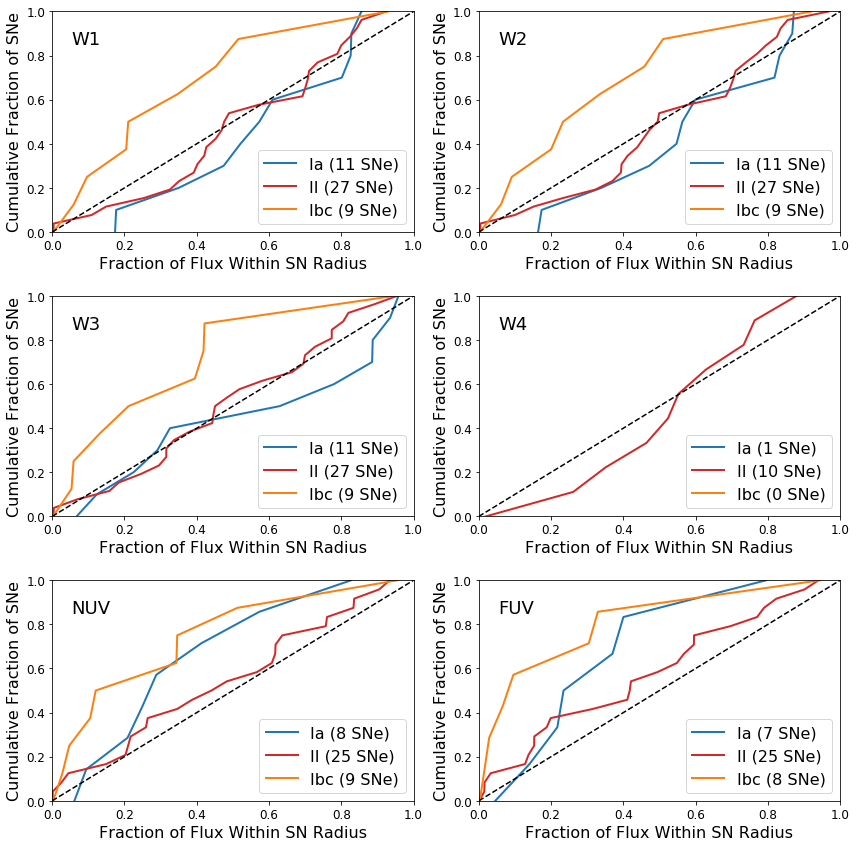

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

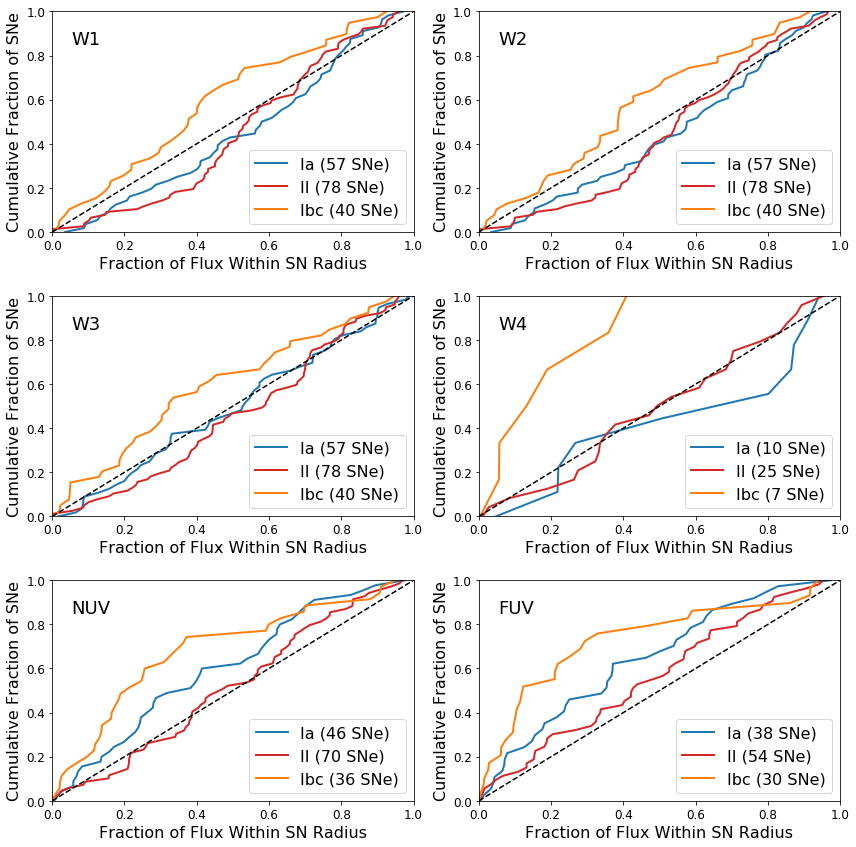

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

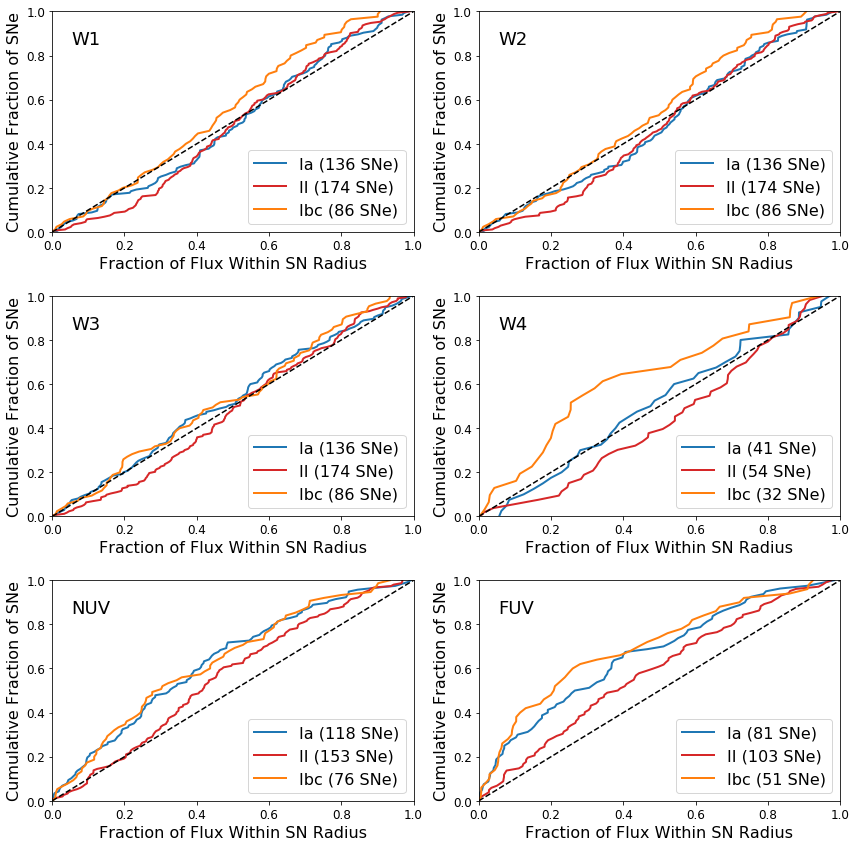

In [11]:
cdf_0p5 = plot_cdfs(sn_conv0p5, '500pc')
cdf_1p0 = plot_cdfs(sn_conv1p0, '1kpc')
cdf_2p0 = plot_cdfs(sn_conv2p0, '2kpc')

Plot the CDFs for the SFR tracer.

In [12]:
def plot_cdfs_sfr(samp, res):
    
    # stuff for the plots
    font = {'family': 'sans-serif',
            'color':  'black',
            'weight': 'normal',
            'size': 18,
            }

    font1 = {'family': 'sans-serif',
            'color':  'black',
            'weight': 'light',
            'style': 'italic',
            'size': 14,
            }
    font_axes = {'family': 'sans-serif',
                'color':  'black',
                'weight': 'normal',
                'size': 16,
                }

    legend  = ['Ia', 'II', 'Ibc']
    colors = ['tab:blue', 'tab:red', 'tab:orange']

    fig = plt.figure(figsize=(6,4))


    #sn types and IR and UV bands
    sn_type = ['Ia', 'II', 'Ib']
    alias1  = ['Ia',  'II','Ic']
    alias2  = ['Ia', 'II', 'Ib/c']
    alias3  = ['Ia', 'II','Ibc']
    bands = ['SFR']

    # FOR KS TEST
    Ia  = []
    II  = []
    Ibc = []
    types = [Ia, II, Ibc]

    # loop over each SN type
    for j in range(len(sn_type)):

        # narrow down the parent table by SN type
        bitmask = (((samp.TYPE == sn_type[j]) |
                    (samp.TYPE == alias1[j]) |
                    (samp.TYPE == alias2[j]) |
                    (samp.TYPE == alias3[j])))
        samp_type = samp[bitmask]

        # loop over the narrowed-down parent table
        sn_cdf_vals = []
        bar = ProgressBar(len(samp_type), ipython_widget=True)
        count = 0
        for index, row in samp_type.iterrows():

            # read in host galaxy control table
            pgc = row['PGC']
            try:
                # read in galaxy CDF file
                gal_cdf_file = pd.read_csv('galaxy_control_tables/gal_cdfs_%s/%s_SFR_%s.csv' % (res, pgc, res))
            except FileNotFoundError:
                bar.update()
                continue

            # round radius values so that np.interp works
            rad = np.array(round(gal_cdf_file['RADIUS'],5))
            cdf = np.array(gal_cdf_file['CDF'])

            try:        
                # get SN radii
                sn_rad = round(row['SN_RAD'],5)

                # get SN cdf val     
                sn_val_cdf = np.interp(sn_rad, rad, cdf)
            except:
                sn_val_cdf = np.nan

            # SN cdf vals
            sn_cdf_vals += [sn_val_cdf]

            bar.update()


        # build the plots for each SN type
        sn_cdf_vals = np.array(sn_cdf_vals)
        sn_cdf_vals = sn_cdf_vals[np.isfinite(sn_cdf_vals)]
        sn_cdf_vals = np.sort(sn_cdf_vals)
        types[j].append(sn_cdf_vals) # for KS test
        plt.plot(sn_cdf_vals, np.linspace(0, 1.0, len(sn_cdf_vals)), color=colors[j], label=legend[j] + ' (%s SNe)' % (len(sn_cdf_vals)), linewidth=2)

    # plot each SN type on one plot for the SFR tracer band
    plt.xlabel('Fraction of Flux Within SN Radius', fontdict=font_axes)
    plt.ylabel('Cumulative Frac. of SNe', fontdict=font_axes)
    plt.legend(loc='lower right',prop={'size': 16})
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.text(0.054, 0.85,'SFR', fontdict=font)   
    plt.plot([0.0,1.0], [0.0,1.0], ls="--", color='black')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('results/%s_SFR.png' % (res), dpi=200)
    plt.show()

    return(types)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

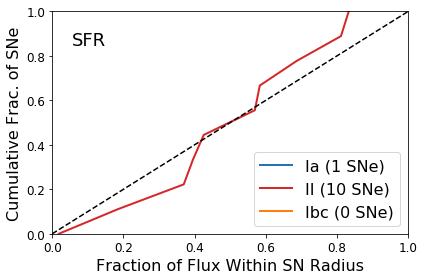

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

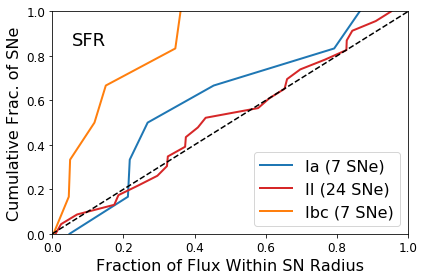

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

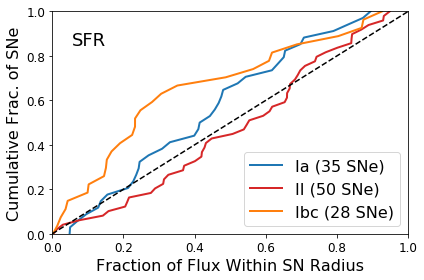

In [13]:
cdf_0p5_sfr = plot_cdfs_sfr(sn_conv0p5, '500pc')
cdf_1p0_sfr = plot_cdfs_sfr(sn_conv1p0, '1kpc')
cdf_2p0_sfr = plot_cdfs_sfr(sn_conv2p0, '2kpc')

### Output the CDFs to file so that we can run a KS test

Output the CDFs of the regular bands.

In [14]:
def output_final_cdfs(band_cdfs_per_type, res):

                                         # type # band
    w1_ia  = pd.DataFrame(band_cdfs_per_type[0][0], columns=['W1_Ia'])
    w1_ii  = pd.DataFrame(band_cdfs_per_type[1][0], columns=['W1_II'])
    w1_ibc = pd.DataFrame(band_cdfs_per_type[2][0], columns=['W1_Ibc'])

    w2_ia  = pd.DataFrame(band_cdfs_per_type[0][1], columns=['W2_Ia'])
    w2_ii  = pd.DataFrame(band_cdfs_per_type[1][1], columns=['W2_II'])
    w2_ibc = pd.DataFrame(band_cdfs_per_type[2][1], columns=['W2_Ibc'])

    w3_ia  = pd.DataFrame(band_cdfs_per_type[0][2], columns=['W3_Ia'])
    w3_ii  = pd.DataFrame(band_cdfs_per_type[1][2], columns=['W3_II'])
    w3_ibc = pd.DataFrame(band_cdfs_per_type[2][2], columns=['W3_Ibc'])

    w4_ia  = pd.DataFrame(band_cdfs_per_type[0][3], columns=['W4_Ia'])
    w4_ii  = pd.DataFrame(band_cdfs_per_type[1][3], columns=['W4_II'])
    w4_ibc = pd.DataFrame(band_cdfs_per_type[2][3], columns=['W4_Ibc'])

    nuv_ia  = pd.DataFrame(band_cdfs_per_type[0][4], columns=['NUV_Ia'])
    nuv_ii  = pd.DataFrame(band_cdfs_per_type[1][4], columns=['NUV_II'])
    nuv_ibc = pd.DataFrame(band_cdfs_per_type[2][4], columns=['NUV_Ibc'])

    fuv_ia  = pd.DataFrame(band_cdfs_per_type[0][5], columns=['FUV_Ia'])
    fuv_ii  = pd.DataFrame(band_cdfs_per_type[1][5], columns=['FUV_II'])
    fuv_ibc = pd.DataFrame(band_cdfs_per_type[2][5], columns=['FUV_Ibc'])

    total = pd.concat([w1_ia,w1_ii,w1_ibc,w2_ia,w2_ii,w2_ibc,w3_ia,w3_ii,w3_ibc,w4_ia,w4_ii,w4_ibc,
                      nuv_ia,nuv_ii,nuv_ibc,fuv_ia,fuv_ii,fuv_ibc], axis=1)
    
    total.to_csv('results/ks_test/%s.csv' % (res), index=False)
    return

In [15]:
output_final_cdfs(cdf_0p5, '500pc')
output_final_cdfs(cdf_1p0, '1kpc')
output_final_cdfs(cdf_2p0, '2kpc')

Now output the CDFs for the SFR tracer.

In [16]:
def output_final_sfr_cdf(cdfs_per_type, res):
    
    ia  = pd.DataFrame(cdfs_per_type[0][0], columns=['SFR_Ia'])
    ii  = pd.DataFrame(cdfs_per_type[1][0], columns=['SFR_II'])
    ibc = pd.DataFrame(cdfs_per_type[2][0], columns=['SFR_Ibc'])

    total = pd.concat([ia,ii,ibc], axis=1)

    total.to_csv('results/ks_test/SFR_%s.csv' % (res), index=False)
    
    return

In [17]:
output_final_sfr_cdf(cdf_0p5_sfr, '500pc')
output_final_sfr_cdf(cdf_1p0_sfr, '1kpc')
output_final_sfr_cdf(cdf_2p0_sfr, '2kpc')

### KS Tests

Run against host galaxy emission.

Define a function that will use the statistic number (D) from the KS-test to tell us if the null hypothesis can be rejected.

In [18]:
def reject(m, n, D):
    calpha = 1.358
    
    val = calpha * np.sqrt((m+n) / (m*n))
    
    if D > val:
        output = 'reject'
    else:
        output = 'cannot reject'
    return(output, val)

Define a function that will perform the KS test for all bands + SFR and create a big DataFrame with all this info.

In [27]:
def ks_galaxy_emission(cdfs, res, ks_test_df, sfr):
    
    stat_length = []
    pval_length = []
    stat_10000 = []
    pval_10000 = []
    reject_length = []
    reject_10000  = []
    vals_length   = []
    vals_10000    = []
    cdf = []
    
    if sfr is True:
        bands = ['SFR']
    else:
        bands = ['W1','W2','W3','W4','NUV','FUV']
        
    for bb in range(len(bands)):
        
        # perform the KS test
        ia_length  = ks_2samp(cdfs['%s_Ia'  % (bands[bb])].dropna(), 
                              np.linspace(0.0, 1.0, len(cdfs['%s_Ia'  % (bands[bb])].dropna())))
        ii_length  = ks_2samp(cdfs['%s_II'  % (bands[bb])].dropna(), 
                              np.linspace(0.0, 1.0, len(cdfs['%s_II'  % (bands[bb])].dropna())))
        # 500pc Ibc = 0
        try: 
            ibc_length = ks_2samp(cdfs['%s_Ibc' % (bands[bb])].dropna(), 
                                  np.linspace(0.0, 1.0, len(cdfs['%s_Ibc'  % (bands[bb])].dropna())))
        except ValueError:
            ibc_length = np.nan

        ia_10000  = ks_2samp(cdfs['%s_Ia'  % (bands[bb])].dropna(), np.linspace(0.0,1.0,10000))
        ii_10000  = ks_2samp(cdfs['%s_II'  % (bands[bb])].dropna(), np.linspace(0.0,1.0,10000))
        
        try:
            ibc_10000 = ks_2samp(cdfs['%s_Ibc' % (bands[bb])].dropna(), np.linspace(0.0,1.0,10000))
        except ValueError:
            ibc_10000 = np.nan
        
        # reject or accpet based on statistic values (D)
        reject_length_ia, val1 = reject(len(cdfs['%s_Ia'  % (bands[bb])].dropna()), 
                                  len(np.linspace(0.0, 1.0, len(cdfs['%s_Ia'  % (bands[bb])].dropna()))), ia_length[0])
        reject_length_ii, val2 = reject(len(cdfs['%s_II'  % (bands[bb])].dropna()), 
                                  len(np.linspace(0.0, 1.0, len(cdfs['%s_II'  % (bands[bb])].dropna()))), ii_length[0])
        
        # 500pc Ibc = 0
        try:
            reject_length_ibc, val3 = reject(len(cdfs['%s_Ibc'  % (bands[bb])].dropna()), 
                                      len(np.linspace(0.0, 1.0, len(cdfs['%s_Ibc'  % (bands[bb])].dropna()))), ibc_length[0])

        except:
            reject_length_ibc = np.nan
            val3 = np.nan
            
        reject_10000_ia, val4 = reject(len(cdfs['%s_Ia'  % (bands[bb])].dropna()), 10000, ia_10000[0])
        reject_10000_ii, val5 = reject(len(cdfs['%s_II'  % (bands[bb])].dropna()), 10000, ii_10000[0])
        
        try:
            reject_10000_ibc, val6 = reject(len(cdfs['%s_Ibc' % (bands[bb])].dropna()), 10000, ibc_10000[0])
        except:
            reject_10000_ibc = np.nan
            val6 = np.nan

        # compile everything into lists
        
        try:
            stat_length += [ia_length[0],ii_length[0],ibc_length[0]]
            stat_10000  += [ia_10000[0],ii_10000[0],ibc_10000[0]]
            pval_length += [ia_length[1],ii_length[1],ibc_length[1]]
            pval_10000  += [ia_10000[1],ii_10000[1],ibc_10000[1]]
        except:
            stat_length += [ia_length[0],ii_length[0],ibc_length]
            stat_10000  += [ia_10000[0],ii_10000[0],ibc_10000]
            pval_length += [ia_length[1],ii_length[1],ibc_length]
            pval_10000  += [ia_10000[1],ii_10000[1],ibc_10000]
        reject_length += [reject_length_ia,reject_length_ii,reject_length_ibc]
        reject_10000  += [reject_10000_ia,reject_10000_ii,reject_10000_ibc]
        vals_length   += [val1,val2,val3]
        vals_10000    += [val4,val5,val6]
        cdf           += ['%s_Ia' % (bands[bb]),'%s_II' % (bands[bb]),'%s_Ibc' % (bands[bb])]
    
    
    # add the lists to the DataFrame
    ks_test_df['CDF'] = cdf
    ks_test_df['STATISTIC (Num. SNe)'] = stat_length
    ks_test_df['STATISTIC (10000)']    = stat_10000
    ks_test_df['PVALUE (Num. SNe)']    = pval_length
    ks_test_df['PVALUE (10000)']       = pval_10000
    ks_test_df['THRESHOLD (Num. SNe)'] = vals_length
    ks_test_df['THRESHOLD (10000)']    = vals_10000
    ks_test_df['REJECT (Num. SNe)']    = reject_length
    ks_test_df['REJECT (10000)']       = reject_10000
    
    return(ks_test_df)

Run this function for all regular bands.

In [32]:
# All regular bands
ks_test = pd.DataFrame()
cdfs_500pc = pd.read_csv('results/ks_test/500pc.csv')
ks_test_500pc = ks_galaxy_emission(cdfs_500pc, '500pc', ks_test, False)

ks_test = pd.DataFrame()
cdfs_1kpc = pd.read_csv('results/ks_test/1kpc.csv')
ks_test_1kpc = ks_galaxy_emission(cdfs_1kpc, '1kpc', ks_test, False)

ks_test = pd.DataFrame()
cdfs_2kpc = pd.read_csv('results/ks_test/2kpc.csv')
ks_test_2kpc = ks_galaxy_emission(cdfs_2kpc, '2kpc', ks_test, False)

# SFR
ks_test = pd.DataFrame()
cdfs_500pc_sfr = pd.read_csv('results/ks_test/SFR_500pc.csv')
ks_test_500pc_sfr = ks_galaxy_emission(cdfs_500pc_sfr, '500pc', ks_test, True)

ks_test = pd.DataFrame()
cdfs_1kpc_sfr = pd.read_csv('results/ks_test/SFR_1kpc.csv')
ks_test_1kpc_sfr = ks_galaxy_emission(cdfs_1kpc_sfr, '1kpc', ks_test, True)

ks_test = pd.DataFrame()
cdfs_2kpc_sfr = pd.read_csv('results/ks_test/SFR_2kpc.csv')
ks_test_2kpc_sfr = ks_galaxy_emission(cdfs_2kpc_sfr, '2kpc', ks_test, True)

Add the SFR tracer results to the regular bands DataFrame and output as a file.

In [33]:
ks_test_500pc = ks_test_500pc.append(ks_test_500pc_sfr)
ks_test_500pc.to_csv('results/ks_test/ks_500pc.csv', index=False)

ks_test_1kpc = ks_test_1kpc.append(ks_test_1kpc_sfr)
ks_test_1kpc.to_csv('results/ks_test/ks_1kpc.csv', index=False)

ks_test_2kpc = ks_test_2kpc.append(ks_test_2kpc_sfr)
ks_test_2kpc.to_csv('results/ks_test/ks_2kpc.csv', index=False)